# Exploring Geometry Tools

This notebook explores how to use the geometry_tools package for line detection and comparison.

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import geometry_tools
from geometry_tools import (
    # Main API functions
    is_line_longer,
    measure_line_length,
    compare_all_lines,
    answer_comparison_question,
    
    # Preprocessing
    load_image,
    preprocess_for_line_detection,
    get_image_info,
    
    # Line detection
    detect_lines_hough,
    detect_and_filter_lines,
    
    # Utilities
    draw_lines_on_image,
    create_synthetic_lines,
    create_muller_lyer_illusion,
    print_comparison_result,
)

plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Sample Images from Benchmark

In [21]:
# Define paths to sample images
DATA_DIR = Path("2821_finalProj_IMAGE_DATA")

# Sample images from different categories
sample_images = {
    "line_yes": DATA_DIR / "vision_1d_Compare_Length/Line_50/line2_YES_000.png",
    "line_no": DATA_DIR / "vision_1d_Compare_Length/Line_50/line2_NO_025.png",
    "arrow_yes": DATA_DIR / "vision_1d_Compare_Length/arrow_100/arrow_YES_000.png",
    "arrow_no": DATA_DIR / "vision_1d_Compare_Length/arrow_100/arrow_NO_050.png",
    "muller_clean_yes": DATA_DIR / "vision_1d_Compare_Length/muller_lyer_150/muller_clean_YES_000.png",
    "muller_clean_no": DATA_DIR / "vision_1d_Compare_Length/muller_lyer_150/muller_clean_NO_025.png",
    "muller_arrows_yes": DATA_DIR / "vision_1d_Compare_Length/muller_lyer_150/muller_allArrows_YES_000.png",
}

# Check which files exist
for name, path in sample_images.items():
    exists = "✓" if path.exists() else "✗"
    print(f"{exists} {name}: {path}")

✓ line_yes: 2821_finalProj_IMAGE_DATA/vision_1d_Compare_Length/Line_50/line2_YES_000.png
✓ line_no: 2821_finalProj_IMAGE_DATA/vision_1d_Compare_Length/Line_50/line2_NO_025.png
✓ arrow_yes: 2821_finalProj_IMAGE_DATA/vision_1d_Compare_Length/arrow_100/arrow_YES_000.png
✗ arrow_no: 2821_finalProj_IMAGE_DATA/vision_1d_Compare_Length/arrow_100/arrow_NO_050.png
✓ muller_clean_yes: 2821_finalProj_IMAGE_DATA/vision_1d_Compare_Length/muller_lyer_150/muller_clean_YES_000.png
✓ muller_clean_no: 2821_finalProj_IMAGE_DATA/vision_1d_Compare_Length/muller_lyer_150/muller_clean_NO_025.png
✓ muller_arrows_yes: 2821_finalProj_IMAGE_DATA/vision_1d_Compare_Length/muller_lyer_150/muller_allArrows_YES_000.png


## 2. Visualize Sample Images

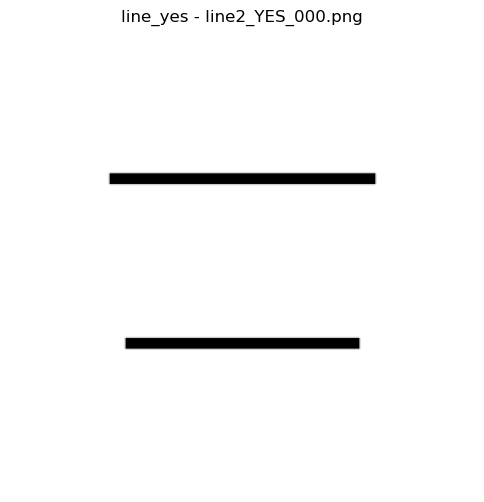

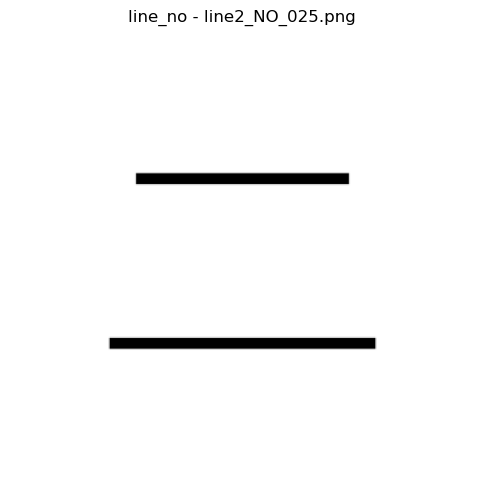

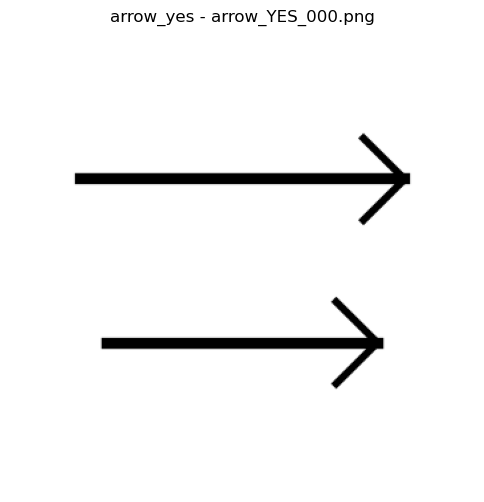

In [22]:
def show_image(image_path, title=""):
    """Display an image."""
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"Could not load: {image_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show a few sample images
for name, path in list(sample_images.items())[:3]:
    if path.exists():
        show_image(path, f"{name} - {path.name}")

## 3. Test Preprocessing Pipeline

In [23]:
# Pick a sample image
test_image_path = sample_images["line_yes"]
print(f"Testing with: {test_image_path}")

# Load image
image = load_image(str(test_image_path))
print(f"Image shape: {image.shape}")
print(f"Image info: {get_image_info(image)}")

Testing with: 2821_finalProj_IMAGE_DATA/vision_1d_Compare_Length/Line_50/line2_YES_000.png
Image shape: (348, 350, 3)
Image info: {'height': 348, 'width': 350, 'channels': 3, 'shape': (348, 350, 3), 'dtype': 'uint8'}


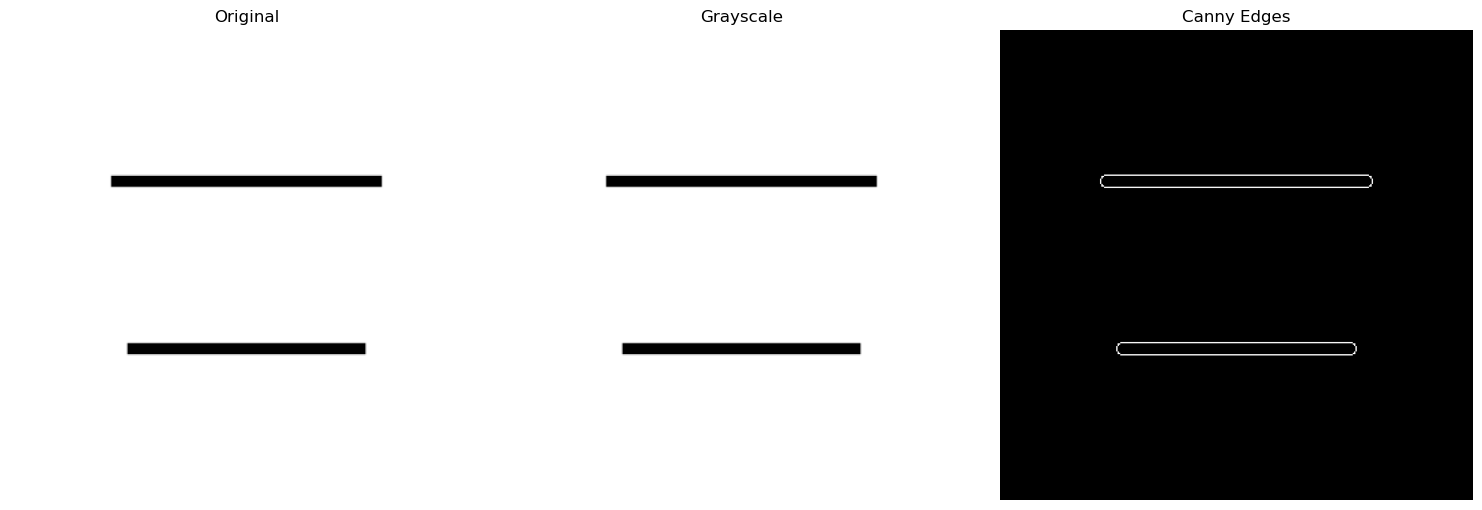

In [24]:
# Apply preprocessing
gray, edges = preprocess_for_line_detection(image)

# Visualize preprocessing steps
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(gray, cmap='gray')
axes[1].set_title("Grayscale")
axes[1].axis('off')

axes[2].imshow(edges, cmap='gray')
axes[2].set_title("Canny Edges")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 4. Test Line Detection

In [25]:
# Detect lines using Hough Transform
raw_lines = detect_lines_hough(edges)
print(f"Raw lines detected: {len(raw_lines) if raw_lines is not None else 0}")

if raw_lines is not None:
    for i, line in enumerate(raw_lines[:5]):  # Show first 5
        x1, y1, x2, y2 = line[0]
        print(f"  Line {i}: ({x1}, {y1}) -> ({x2}, {y2})")

Raw lines detected: 4
  Line 0: (77, 116) -> (272, 116)
  Line 1: (89, 231) -> (260, 231)
  Line 2: (77, 107) -> (272, 107)
  Line 3: (89, 240) -> (260, 240)


In [26]:
# Detect and filter lines (with horizontal filtering and merging)
filtered_lines = detect_and_filter_lines(edges, filter_horizontal=True, merge_duplicates=True)
print(f"Filtered lines: {len(filtered_lines)}")

for line in filtered_lines:
    print(f"  {line['id']}: length={line['length']:.1f}px, angle={line['angle']:.1f}°")
    print(f"    endpoints: {line['endpoints']}")
    print(f"    midpoint: {line['midpoint']}")

Filtered lines: 2
  line_0: length=195.0px, angle=0.0°
    endpoints: [(77, 116), (272, 116)]
    midpoint: (174.5, 116.0)
  line_1: length=171.0px, angle=0.0°
    endpoints: [(89, 231), (260, 231)]
    midpoint: (174.5, 231.0)


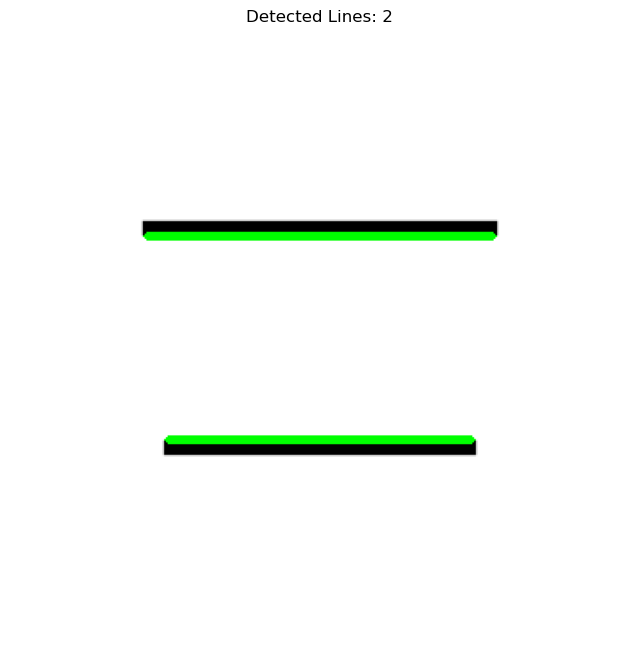

In [27]:
# Visualize detected lines
if filtered_lines:
    image_with_lines = draw_lines_on_image(image, filtered_lines, color=(0, 255, 0), thickness=3)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Lines: {len(filtered_lines)}")
    plt.axis('off')
    plt.show()

## 5. Test Main API Functions

### 5.1 `compare_all_lines()`

In [28]:
# Test compare_all_lines
result = compare_all_lines(str(test_image_path))

print("compare_all_lines() result:")
print(f"  success: {result.get('success')}")
print(f"  num_lines: {result.get('num_lines')}")
print(f"  longest_line: {result.get('longest_line')}")
print(f"  longest_length: {result.get('longest_length')}")
print(f"  shortest_line: {result.get('shortest_line')}")
print(f"  shortest_length: {result.get('shortest_length')}")

if result.get('success'):
    print("\n  Lines detected:")
    for line in result.get('lines', []):
        print(f"    {line['id']}: {line['length']:.1f}px")

compare_all_lines() result:
  success: True
  num_lines: 2
  longest_line: line_0
  longest_length: 195.0
  shortest_line: line_1
  shortest_length: 171.0

  Lines detected:
    line_0: 195.0px
    line_1: 171.0px


### 5.2 `is_line_longer()`

In [29]:
# Test is_line_longer
result = is_line_longer(str(test_image_path), "line_0", "line_1")

print("is_line_longer('line_0', 'line_1') result:")
print(f"  success: {result.get('success')}")
print(f"  answer: {result.get('answer')}")
print(f"  answer_text: {result.get('answer_text')}")
print(f"  line_A_length: {result.get('line_A_length')}")
print(f"  line_B_length: {result.get('line_B_length')}")
print(f"  difference: {result.get('difference')}")
print(f"  relative_difference: {result.get('relative_difference')}")
print(f"  confidence: {result.get('confidence')}")
print(f"  are_equal: {result.get('are_equal')}")

if result.get('error'):
    print(f"  ERROR: {result.get('error')}")

is_line_longer('line_0', 'line_1') result:
  success: True
  answer: True
  answer_text: yes
  line_A_length: 195.0
  line_B_length: 171.0
  difference: 24.0
  relative_difference: 0.12307692307692308
  confidence: medium
  are_equal: False


### 5.3 `measure_line_length()`

In [30]:
# Test measure_line_length
result = measure_line_length(str(test_image_path), "line_0")

print("measure_line_length('line_0') result:")
print(f"  success: {result.get('success')}")
print(f"  length: {result.get('length')}")
print(f"  line_id: {result.get('line_id')}")

if result.get('error'):
    print(f"  ERROR: {result.get('error')}")

measure_line_length('line_0') result:
  success: True
  length: 195.0
  line_id: line_0


## 6. Test on Multiple Image Types

In [31]:
def test_image(image_path, expected_answer):
    """Test geometry_tools on an image and check against expected answer."""
    print(f"\n{'='*60}")
    print(f"Testing: {Path(image_path).name}")
    print(f"Expected: {'YES (top longer)' if expected_answer else 'NO (bottom longer)'}")
    print(f"{'='*60}")
    
    # First, see what lines are detected
    all_lines = compare_all_lines(str(image_path))
    
    if not all_lines.get('success'):
        print(f"FAILED: {all_lines.get('error')}")
        return None
    
    print(f"\nLines detected: {all_lines.get('num_lines')}")
    lines = all_lines.get('lines', [])
    
    for line in lines:
        y_pos = line['midpoint'][1]
        pos_label = "TOP" if y_pos < 200 else "BOTTOM"
        print(f"  {line['id']}: {line['length']:.1f}px, y={y_pos:.0f} ({pos_label})")
    
    # IMPORTANT: Find which line is TOP and which is BOTTOM by Y coordinate
    # Smaller Y = higher on screen = TOP
    if len(lines) < 2:
        print("ERROR: Need at least 2 lines")
        return None
    
    # Sort by Y position to find top and bottom
    sorted_by_y = sorted(lines, key=lambda l: l['midpoint'][1])
    top_line = sorted_by_y[0]  # Smallest Y = TOP
    bottom_line = sorted_by_y[1]  # Larger Y = BOTTOM
    
    print(f"\n  TOP line: {top_line['id']} ({top_line['length']:.1f}px, y={top_line['midpoint'][1]:.0f})")
    print(f"  BOTTOM line: {bottom_line['id']} ({bottom_line['length']:.1f}px, y={bottom_line['midpoint'][1]:.0f})")
    
    # Compare: Is TOP line longer than BOTTOM line?
    top_longer = top_line['length'] > bottom_line['length']
    
    print(f"\n  Is TOP ({top_line['length']:.1f}px) > BOTTOM ({bottom_line['length']:.1f}px)?")
    print(f"  Predicted: {'YES' if top_longer else 'NO'}")
    print(f"  Expected:  {'YES' if expected_answer else 'NO'}")
    print(f"  Correct:   {'✓' if top_longer == expected_answer else '✗'}")
    
    return top_longer == expected_answer

In [32]:
# Test on sample images
test_cases = [
    ("line_yes", True),
    ("line_no", False),
]

results = []
for name, expected in test_cases:
    if sample_images[name].exists():
        correct = test_image(sample_images[name], expected)
        results.append((name, correct))

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
for name, correct in results:
    status = "✓" if correct else "✗" if correct is not None else "?"
    print(f"  {status} {name}")


Testing: line2_YES_000.png
Expected: YES (top longer)

Lines detected: 2
  line_0: 195.0px, y=116 (TOP)
  line_1: 171.0px, y=231 (BOTTOM)

  TOP line: line_0 (195.0px, y=116)
  BOTTOM line: line_1 (171.0px, y=231)

  Is TOP (195.0px) > BOTTOM (171.0px)?
  Predicted: YES
  Expected:  YES
  Correct:   ✓

Testing: line2_NO_025.png
Expected: NO (bottom longer)

Lines detected: 2
  line_0: 195.0px, y=240 (BOTTOM)
  line_1: 155.0px, y=107 (TOP)

  TOP line: line_1 (155.0px, y=107)
  BOTTOM line: line_0 (195.0px, y=240)

  Is TOP (155.0px) > BOTTOM (195.0px)?
  Predicted: NO
  Expected:  NO
  Correct:   ✓

SUMMARY
  ✓ line_yes
  ✓ line_no


## 7. Investigate Line ID Assignment

The key question: How are line IDs assigned? Is `line_0` always the top line?

In [33]:
def analyze_line_positions(image_path):
    """Analyze which line is top vs bottom based on y-coordinates."""
    print(f"\nAnalyzing: {Path(image_path).name}")
    
    result = compare_all_lines(str(image_path))
    
    if not result.get('success'):
        print(f"  Error: {result.get('error')}")
        return
    
    lines = result.get('lines', [])
    
    for line in lines:
        line_id = line['id']
        midpoint = line['midpoint']
        length = line['length']
        endpoints = line['endpoints']
        
        # Y coordinate: smaller = higher on screen (top)
        y_pos = midpoint[1]
        
        print(f"  {line_id}:")
        print(f"    length: {length:.1f}px")
        print(f"    midpoint: ({midpoint[0]:.1f}, {midpoint[1]:.1f})")
        print(f"    y-position: {y_pos:.1f} ({'TOP' if y_pos < 200 else 'BOTTOM'})")
        print(f"    endpoints: {endpoints}")

In [34]:
# Analyze several images
for name in ["line_yes", "line_no"]:
    if sample_images[name].exists():
        analyze_line_positions(sample_images[name])


Analyzing: line2_YES_000.png
  line_0:
    length: 195.0px
    midpoint: (174.5, 116.0)
    y-position: 116.0 (TOP)
    endpoints: [(77, 116), (272, 116)]
  line_1:
    length: 171.0px
    midpoint: (174.5, 231.0)
    y-position: 231.0 (BOTTOM)
    endpoints: [(89, 231), (260, 231)]

Analyzing: line2_NO_025.png
  line_0:
    length: 195.0px
    midpoint: (174.5, 240.0)
    y-position: 240.0 (BOTTOM)
    endpoints: [(77, 240), (272, 240)]
  line_1:
    length: 155.0px
    midpoint: (174.5, 107.0)
    y-position: 107.0 (TOP)
    endpoints: [(97, 107), (252, 107)]


## 8. Test Arrow and Müller-Lyer Images


Analyzing: arrow_YES_000.png
  line_0:
    length: 247.0px
    midpoint: (174.5, 116.0)
    y-position: 116.0 (TOP)
    endpoints: [(51, 116), (298, 116)]
  line_1:
    length: 207.0px
    midpoint: (174.5, 240.0)
    y-position: 240.0 (BOTTOM)
    endpoints: [(71, 240), (278, 240)]


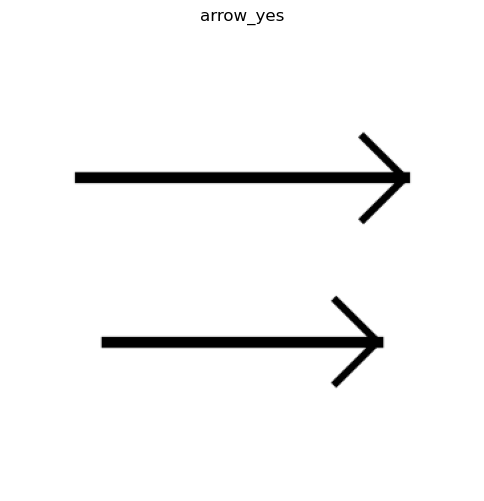

In [35]:
# Test on arrow images
for name in ["arrow_yes", "arrow_no"]:
    if sample_images[name].exists():
        analyze_line_positions(sample_images[name])
        show_image(sample_images[name], name)


Analyzing: muller_clean_YES_000.png
  line_0:
    length: 220.0px
    midpoint: (167.0, 103.0)
    y-position: 103.0 (TOP)
    endpoints: [(57, 103), (277, 103)]
  line_1:
    length: 198.0px
    midpoint: (182.0, 227.0)
    y-position: 227.0 (BOTTOM)
    endpoints: [(83, 227), (281, 227)]


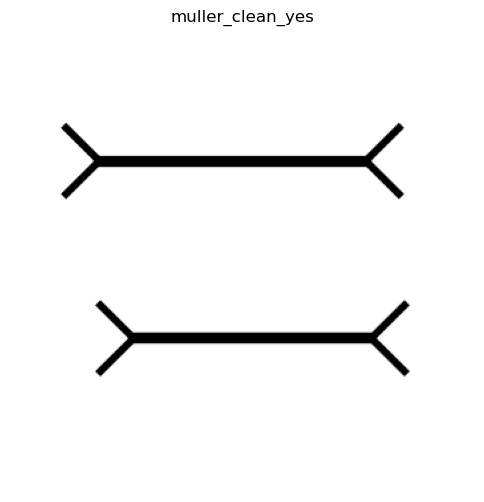


Analyzing: muller_clean_NO_025.png
  line_0:
    length: 212.0px
    midpoint: (169.0, 220.0)
    y-position: 220.0 (BOTTOM)
    endpoints: [(63, 220), (275, 220)]
  line_1:
    length: 174.0px
    midpoint: (180.0, 120.0)
    y-position: 120.0 (TOP)
    endpoints: [(93, 120), (267, 120)]


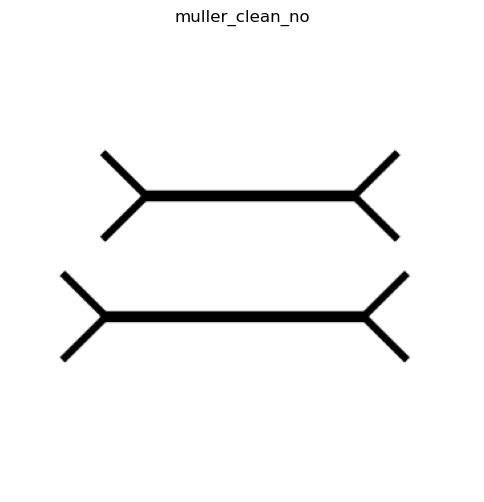


Analyzing: muller_allArrows_YES_000.png
  line_0:
    length: 173.0px
    midpoint: (190.5, 127.0)
    y-position: 127.0 (TOP)
    endpoints: [(104, 127), (277, 127)]
  line_1:
    length: 153.0px
    midpoint: (159.5, 225.0)
    y-position: 225.0 (BOTTOM)
    endpoints: [(83, 225), (236, 225)]


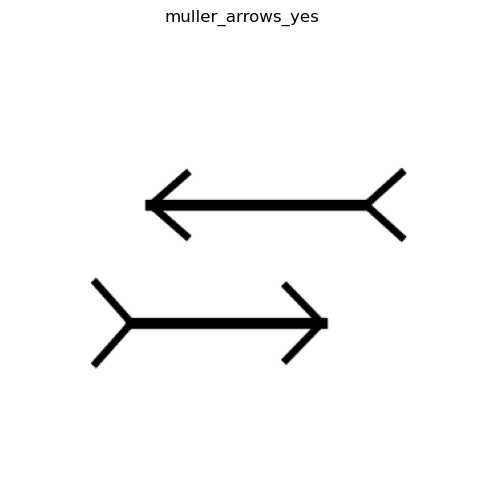

In [36]:
# Test on Müller-Lyer images
for name in ["muller_clean_yes", "muller_clean_no", "muller_arrows_yes"]:
    if sample_images[name].exists():
        analyze_line_positions(sample_images[name])
        show_image(sample_images[name], name)

## 9. Debug: Visualize All Detected Lines with Labels

In [37]:
def visualize_detected_lines(image_path):
    """Visualize detected lines with ID labels."""
    image = load_image(str(image_path))
    gray, edges = preprocess_for_line_detection(image)
    lines = detect_and_filter_lines(edges, filter_horizontal=True)
    
    # Draw lines with labels
    result_image = image.copy()
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0)]  # Green, Blue, Red, Yellow
    
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line['coordinates']
        color = colors[i % len(colors)]
        
        # Draw line
        cv2.line(result_image, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)
        
        # Add label at midpoint
        mx, my = line['midpoint']
        label = f"{line['id']}: {line['length']:.0f}px"
        cv2.putText(result_image, label, (int(mx) - 50, int(my) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # Display
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Original: {Path(image_path).name}")
    axes[0].axis('off')
    
    axes[1].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Detected Lines: {len(lines)}")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return lines


line_yes:


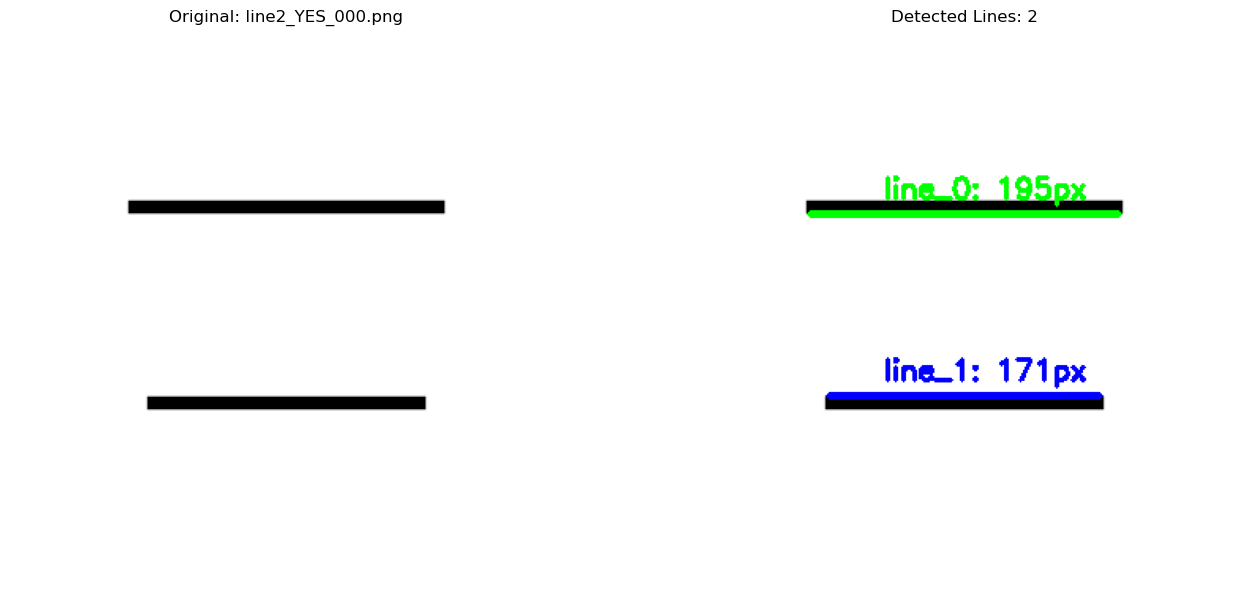


line_no:


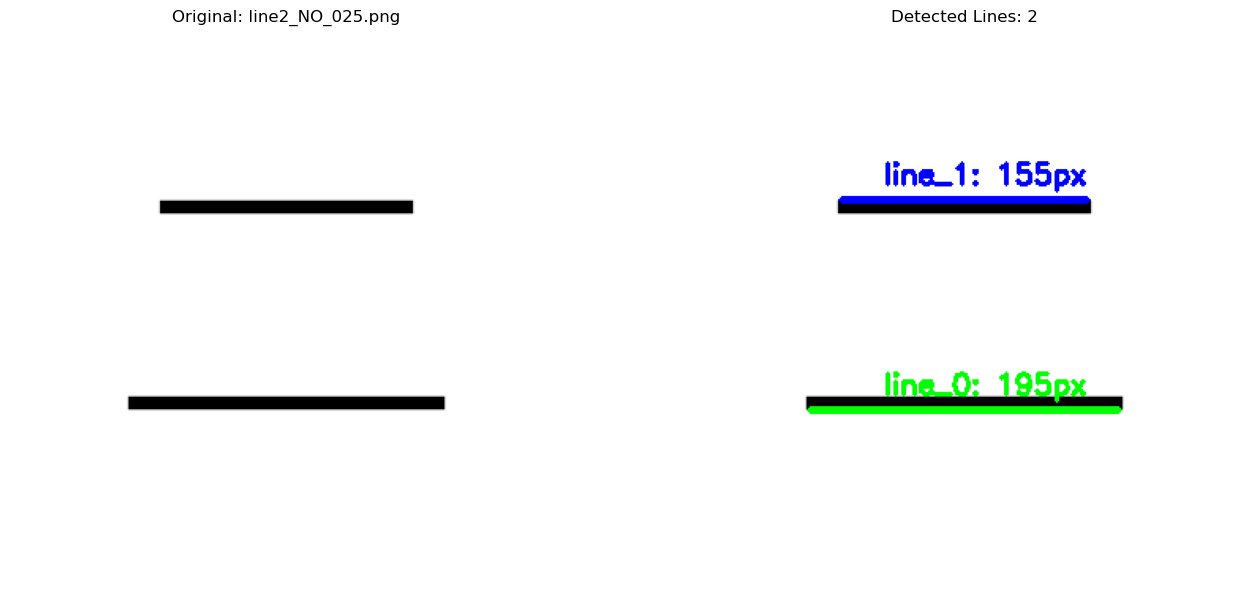


arrow_yes:


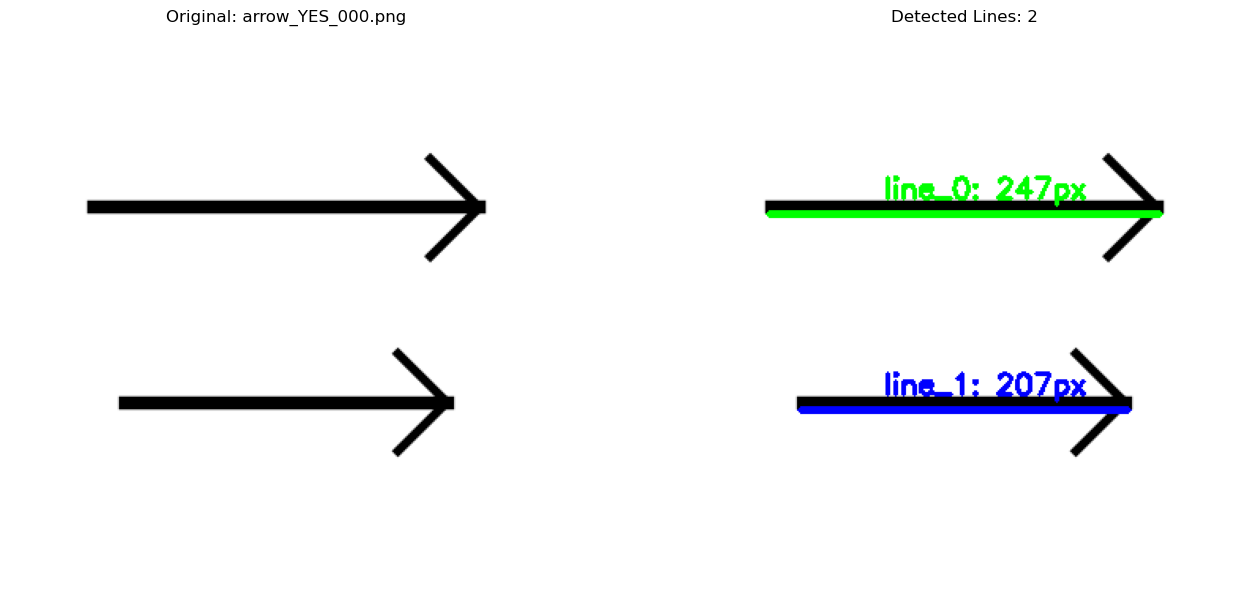

In [38]:
# Visualize detected lines on sample images
for name in ["line_yes", "line_no", "arrow_yes"]:
    if sample_images[name].exists():
        print(f"\n{name}:")
        lines = visualize_detected_lines(sample_images[name])

## 10. Conclusions & Issues Found

Document any issues discovered during exploration:

In [39]:
# Summary of findings
print("""
FINDINGS:
=========

1. Line ID Assignment:
   - How are line_0, line_1 assigned?
   - Is line_0 always the TOP line?
   - [Fill in after running notebook]

2. Detection Accuracy:
   - How many lines are detected in simple line images?
   - How many lines are detected in arrow images?
   - How many lines are detected in Müller-Lyer images?
   - [Fill in after running notebook]

3. Issues Found:
   - [List any issues]

4. Recommendations:
   - [List any fixes needed]
""")


FINDINGS:

1. Line ID Assignment:
   - How are line_0, line_1 assigned?
   - Is line_0 always the TOP line?
   - [Fill in after running notebook]

2. Detection Accuracy:
   - How many lines are detected in simple line images?
   - How many lines are detected in arrow images?
   - How many lines are detected in Müller-Lyer images?
   - [Fill in after running notebook]

3. Issues Found:
   - [List any issues]

4. Recommendations:
   - [List any fixes needed]

